# GSM6614348 Analysis with AIDO Cell Embedding Generation

This notebook demonstrates:
1. Loading GSM6614348 HC-1 dataset from GEO
2. Generating AIDO Cell embeddings (like in main.py)
3. UMAP and Clustering

In [1]:
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from pathlib import Path
from typing import Optional, Tuple

# Set up scanpy settings
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white')

# Check device availability
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print(f"Using device: {device}")

Using device: mps


## Configuration

In [2]:
# Configuration parameters
DATA_PATH = 'data'  # Path to data directory
OUTPUT_DIR = Path('output/GSM6614348_notebook')
BATCH_SIZE = 2  # Adjust based on your GPU memory
MIN_GENES = 500  # Min genes per cell
MIN_CELLS = 3  # Min cells per gene
MAX_CELLS = None  # Set to limit number of cells for testing
N_NEIGHBORS = 15  # For UMAP
RESOLUTION = 1.0  # For Leiden clustering

# Create output directory
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
print(f"Output directory: {OUTPUT_DIR}")

Output directory: output/GSM6614348_notebook


## Load and Preprocess Data

### Download data from GEO and load into anndata

In [3]:
%%bash
mkdir -p data
cd data

# Check if data already exists
if [ -f "GSM6614348_HC-1_matrix.mtx.gz" ]; then
    echo "Data files already exist. Skipping download."
else
    echo "Downloading GSE214695 dataset from GEO..."
    wget -nv -O GSE214695.tar 'http://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE214695&format=file'
    echo "Extracting files..."
    tar -xf GSE214695.tar
    rm GSE214695.tar
    echo "Dataset downloaded and extracted."
fi

# List GSM6614348 files
echo "\nGSM6614348 HC-1 files:"
ls -lh GSM6614348_HC-1_*

2025-08-26 10:41:36 URL:http://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE214695&format=file [887091200/887091200] -> "GSE214695.tar" [1]


Extracting files...
Dataset downloaded and extracted.
\nGSM6614348 HC-1 files:
-rw-r--r--  1 kunim2  staff   2.4M Sep 29  2022 GSM6614348_HC-1_barcodes.tsv.gz
-rw-r--r--  1 kunim2  staff   298K Sep 29  2022 GSM6614348_HC-1_features.tsv.gz
-rw-r--r--  1 kunim2  staff    11M Sep 29  2022 GSM6614348_HC-1_matrix.mtx.gz


In [4]:
# Load GSM6614348 HC-1 data
print(f"Loading data from {DATA_PATH}")
adata = sc.read_10x_mtx(DATA_PATH, prefix='GSM6614348_HC-1_')

print(f"Initial shape: {adata.shape}")

# Basic filtering
sc.pp.filter_cells(adata, min_genes=MIN_GENES)
sc.pp.filter_genes(adata, min_cells=MIN_CELLS)
print(f"After filtering: {adata.shape}")

# Optional: subset for testing
if MAX_CELLS:
    adata = adata[:MAX_CELLS].copy()
    print(f"Using subset: {adata.shape[0]} cells")

# No normalization needed - AIDO Cell uses raw counts

Loading data from data
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Initial shape: (737280, 33538)
filtered out 735834 cells that have less than 500 genes expressed
filtered out 17683 genes that are detected in less than 3 cells
After filtering: (1446, 15855)


## Import Required Modules

For running from the experiments directory, we need to add parent paths for imports

In [5]:
import sys
import os

# Add parent directories to path if running from experiments folder
if 'experiments' in str(Path.cwd()):
    parent_dir = Path('../../../').resolve()
    if str(parent_dir) not in sys.path:
        sys.path.insert(0, str(parent_dir))
        print(f"Added {parent_dir} to Python path")

# Import cell_utils
try:
    import cell_utils
    print("Successfully imported cell_utils")
except ImportError as e:
    print(f"Warning: Could not import cell_utils: {e}")
    print("Make sure you're running from the correct directory")

Added /Users/kunim2/bin/genbio to Python path
Successfully imported cell_utils


## Generate AIDO Cell Embeddings

This section replicates the embedding generation from main.py

In [6]:
def generate_embeddings(adata: ad.AnnData, batch_size: int = 2, device: str = 'mps') -> np.ndarray:
    """Generate AIDO Cell embeddings for the given adata.
    
    Args:
        adata: AnnData object with gene expression data
        batch_size: Batch size for processing
        device: Device to use (cuda, mps, cpu)
    
    Returns:
        Array of embeddings with shape (n_cells, embedding_dim)
    """
    import cell_utils
    
    # Align adata to model's expected gene set
    print("Aligning data to model gene set...")
    aligned_adata, attention_mask = cell_utils.align_adata(adata)
    print(f"Aligned shape: {aligned_adata.shape}")
    
    # Load model
    from modelgenerator.tasks import Embed
    
    print("Loading AIDO Cell model...")
    model = Embed.from_config({
        "model.backbone": "aido_cell_3m",
        "model.batch_size": batch_size
    }).eval()
    model = model.to(device).to(torch.bfloat16)
    print("Model loaded successfully")
    
    # Process cells in batches
    all_embeddings = []
    
    with torch.no_grad():
        for i in range(0, aligned_adata.shape[0], batch_size):
            end = min(i + batch_size, aligned_adata.shape[0])
            
            # Get batch data
            batch_np = aligned_adata[i:end].X.toarray()
            batch_tensor = torch.from_numpy(batch_np).to(torch.bfloat16).to(device)
            
            # Transform and embed
            batch_transformed = model.transform({'sequences': batch_tensor})
            embs = model(batch_transformed)
            
            # Apply attention mask and pool
            embs = embs[:, attention_mask.astype(bool), :]
            pooled = embs.mean(dim=1)
            
            all_embeddings.append(pooled.detach().cpu().float().numpy())
            
            if i % 100 == 0:
                print(f"Processed {end}/{aligned_adata.shape[0]} cells")
    
    all_embeddings = np.vstack(all_embeddings)
    print(f"\nGenerated embeddings shape: {all_embeddings.shape}")
    return all_embeddings

In [7]:
# Generate embeddings
print(f"\nGenerating AIDO Cell embeddings for {adata.shape[0]} cells...")
embeddings = generate_embeddings(adata, batch_size=BATCH_SIZE, device=device)

# Add embeddings to adata
adata.obsm['X_aido'] = embeddings
print(f"Added embeddings to adata.obsm['X_aido']")

# Save embeddings
np.save(OUTPUT_DIR / "embeddings.npy", embeddings)
print(f"Saved raw embeddings to {OUTPUT_DIR / 'embeddings.npy'}")

# Save adata with embeddings
adata.write(OUTPUT_DIR / "adata_with_embeddings.h5ad")
print(f"Saved adata with embeddings to {OUTPUT_DIR / 'adata_with_embeddings.h5ad'}")


Generating AIDO Cell embeddings for 1446 cells...
Aligning data to model gene set...
###########  Aligning data to AIDO.Cell  ###########
AIDO.Cell was pretrained on a fixed set of 19264 genes.
Aligning your data to the AIDO.Cell gene set...
2428 in your data that cannot be used by AIDO.Cell. Removing these.
['A1BG-AS1' 'A2M-AS1' 'AAED1' ... 'ZNRD1' 'ZNRF3-AS1' 'ZSCAN16-AS1']
5837 genes in the AIDO.Cell pretraining set missing in your data.
AIDO.Cell is trained with zero-masking. Setting these to zero for AIDO.Cell to ignore.
['A2ML1' 'A3GALT2' 'A4GNT' ... 'ZSWIM5' 'ZYG11A' 'ZZZ3']
13427 non-zero genes remaining.
Reordering genes to match AIDO.Cell gene ordering
Gathering attention mask for nonzero genes
####################  Finished  ####################
Aligned shape: (1446, 19264)
Loading AIDO Cell model...


/Users/kunim2/bin/genbio/aido-cell-env/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Model loaded successfully


/Users/kunim2/bin/genbio/aido-cell-env/lib/python3.10/site-packages/modelgenerator/tasks/tasks.py:1648: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids, dtype=torch.long).to(self.device)
/Users/kunim2/bin/genbio/aido-cell-env/lib/python3.10/site-packages/modelgenerator/backbones/backbones.py:836: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(


Processed 2/1446 cells
Processed 102/1446 cells
Processed 202/1446 cells
Processed 302/1446 cells
Processed 402/1446 cells
Processed 502/1446 cells
Processed 602/1446 cells
Processed 702/1446 cells
Processed 802/1446 cells
Processed 902/1446 cells
Processed 1002/1446 cells
Processed 1102/1446 cells
Processed 1202/1446 cells
Processed 1302/1446 cells
Processed 1402/1446 cells

Generated embeddings shape: (1446, 128)
Added embeddings to adata.obsm['X_aido']
Saved raw embeddings to output/GSM6614348_notebook/embeddings.npy
Saved adata with embeddings to output/GSM6614348_notebook/adata_with_embeddings.h5ad


## Compute UMAP and Clustering

In [8]:
# Compute neighbors using AIDO embeddings
print("\nComputing neighbors based on AIDO embeddings...")
sc.pp.neighbors(adata, use_rep='X_aido', n_neighbors=N_NEIGHBORS)

# Compute UMAP
print("Computing UMAP...")
sc.tl.umap(adata)

# Perform Leiden clustering
print("Performing Leiden clustering...")
sc.tl.leiden(adata, resolution=RESOLUTION)
print(f"Found {len(adata.obs['leiden'].unique())} clusters")


Computing neighbors based on AIDO embeddings...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
Computing UMAP...
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:01)
Performing Leiden clustering...
running Leiden clustering
    finished: found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
Found 17 clusters


/var/folders/8y/ph09xyts1mlc3d_jm8zbpqqh0000gn/T/ipykernel_47360/1467609896.py:11: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=RESOLUTION)


## Visualizations

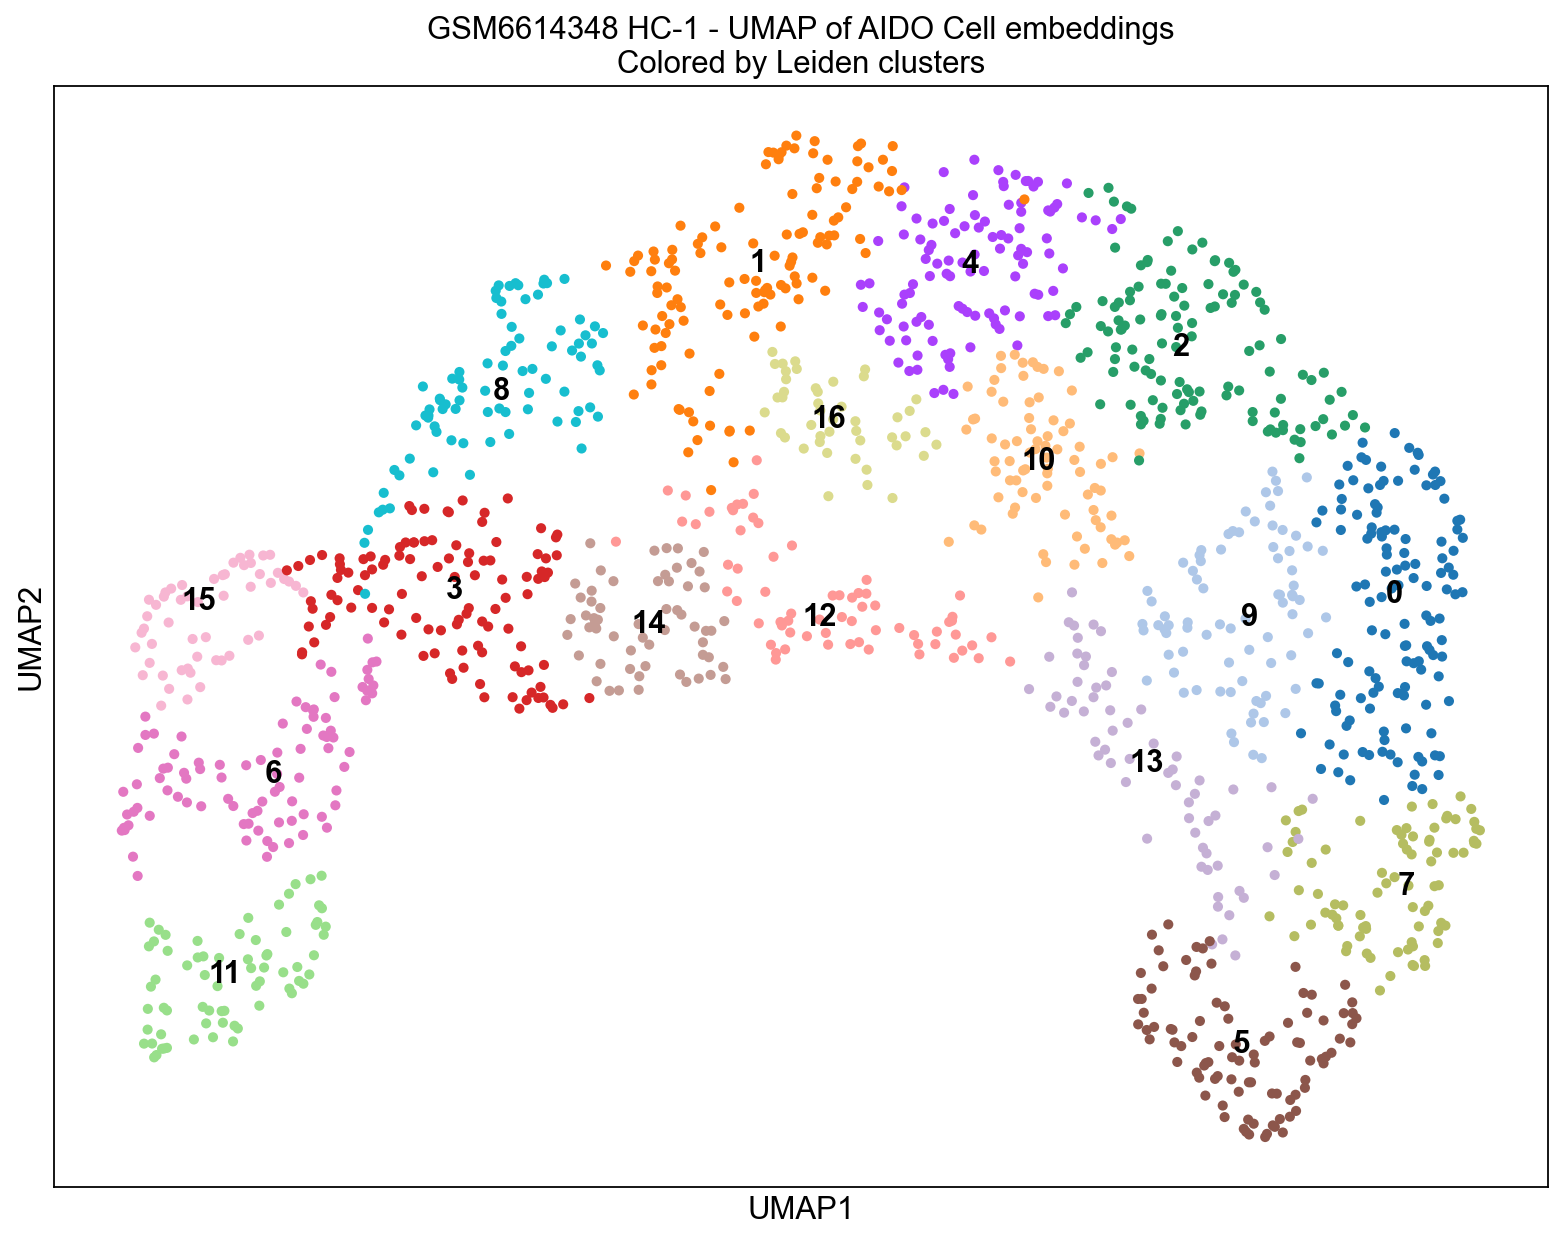

Saved UMAP plot to output/GSM6614348_notebook/umap_leiden.png


In [9]:
# UMAP colored by Leiden clusters
fig, ax = plt.subplots(figsize=(10, 8))
sc.pl.umap(adata, color='leiden', ax=ax, show=False, legend_loc='on data')
plt.title('GSM6614348 HC-1 - UMAP of AIDO Cell embeddings\nColored by Leiden clusters')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "umap_leiden.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved UMAP plot to {OUTPUT_DIR / 'umap_leiden.png'}")

## Save Final Results

In [14]:
# Save the final processed adata
adata.write(OUTPUT_DIR / "adata_processed.h5ad")
print(f"\nSaved processed adata to {OUTPUT_DIR / 'adata_processed.h5ad'}")

# Summary
print(f"\n" + "="*50)
print("Summary:")
print(f"- Processed {adata.shape[0]} cells")
print(f"- Generated {embeddings.shape[1]}-dimensional embeddings")
print(f"- Found {len(adata.obs['leiden'].unique())} clusters")
print(f"- All outputs saved to: {OUTPUT_DIR}")
print("="*50)


Saved processed adata to output/GSM6614348_notebook/adata_processed.h5ad

Summary:
- Processed 1446 cells
- Generated 128-dimensional embeddings
- Found 17 clusters
- All outputs saved to: output/GSM6614348_notebook


## Optional: Compare with Standard PCA-based Analysis

This section compares AIDO embeddings with traditional PCA-based analysis.

In [15]:
# Create a copy for standard analysis
adata_standard = adata.copy()

# Standard preprocessing
print("Performing standard scanpy preprocessing...")
sc.pp.normalize_total(adata_standard, target_sum=1e4)
sc.pp.log1p(adata_standard)
sc.pp.highly_variable_genes(adata_standard, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata_standard.raw = adata_standard
adata_standard = adata_standard[:, adata_standard.var.highly_variable]
sc.pp.scale(adata_standard, max_value=10)
sc.tl.pca(adata_standard, svd_solver='arpack')

# Compute neighbors and UMAP using PCA
sc.pp.neighbors(adata_standard, n_neighbors=N_NEIGHBORS, n_pcs=40)
sc.tl.umap(adata_standard)
sc.tl.leiden(adata_standard, resolution=RESOLUTION)

print(f"Standard analysis: Found {len(adata_standard.obs['leiden'].unique())} clusters")

Performing standard scanpy preprocessing...
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=50


/Users/kunim2/bin/genbio/aido-cell-env/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/kunim2/.local/share/uv/python/cpython-3.10.18-macos-aarch64-none/lib/python3.10/functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:01)
running Leiden clustering
    finished: found 16 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
Standard analysis: Found 16 clusters


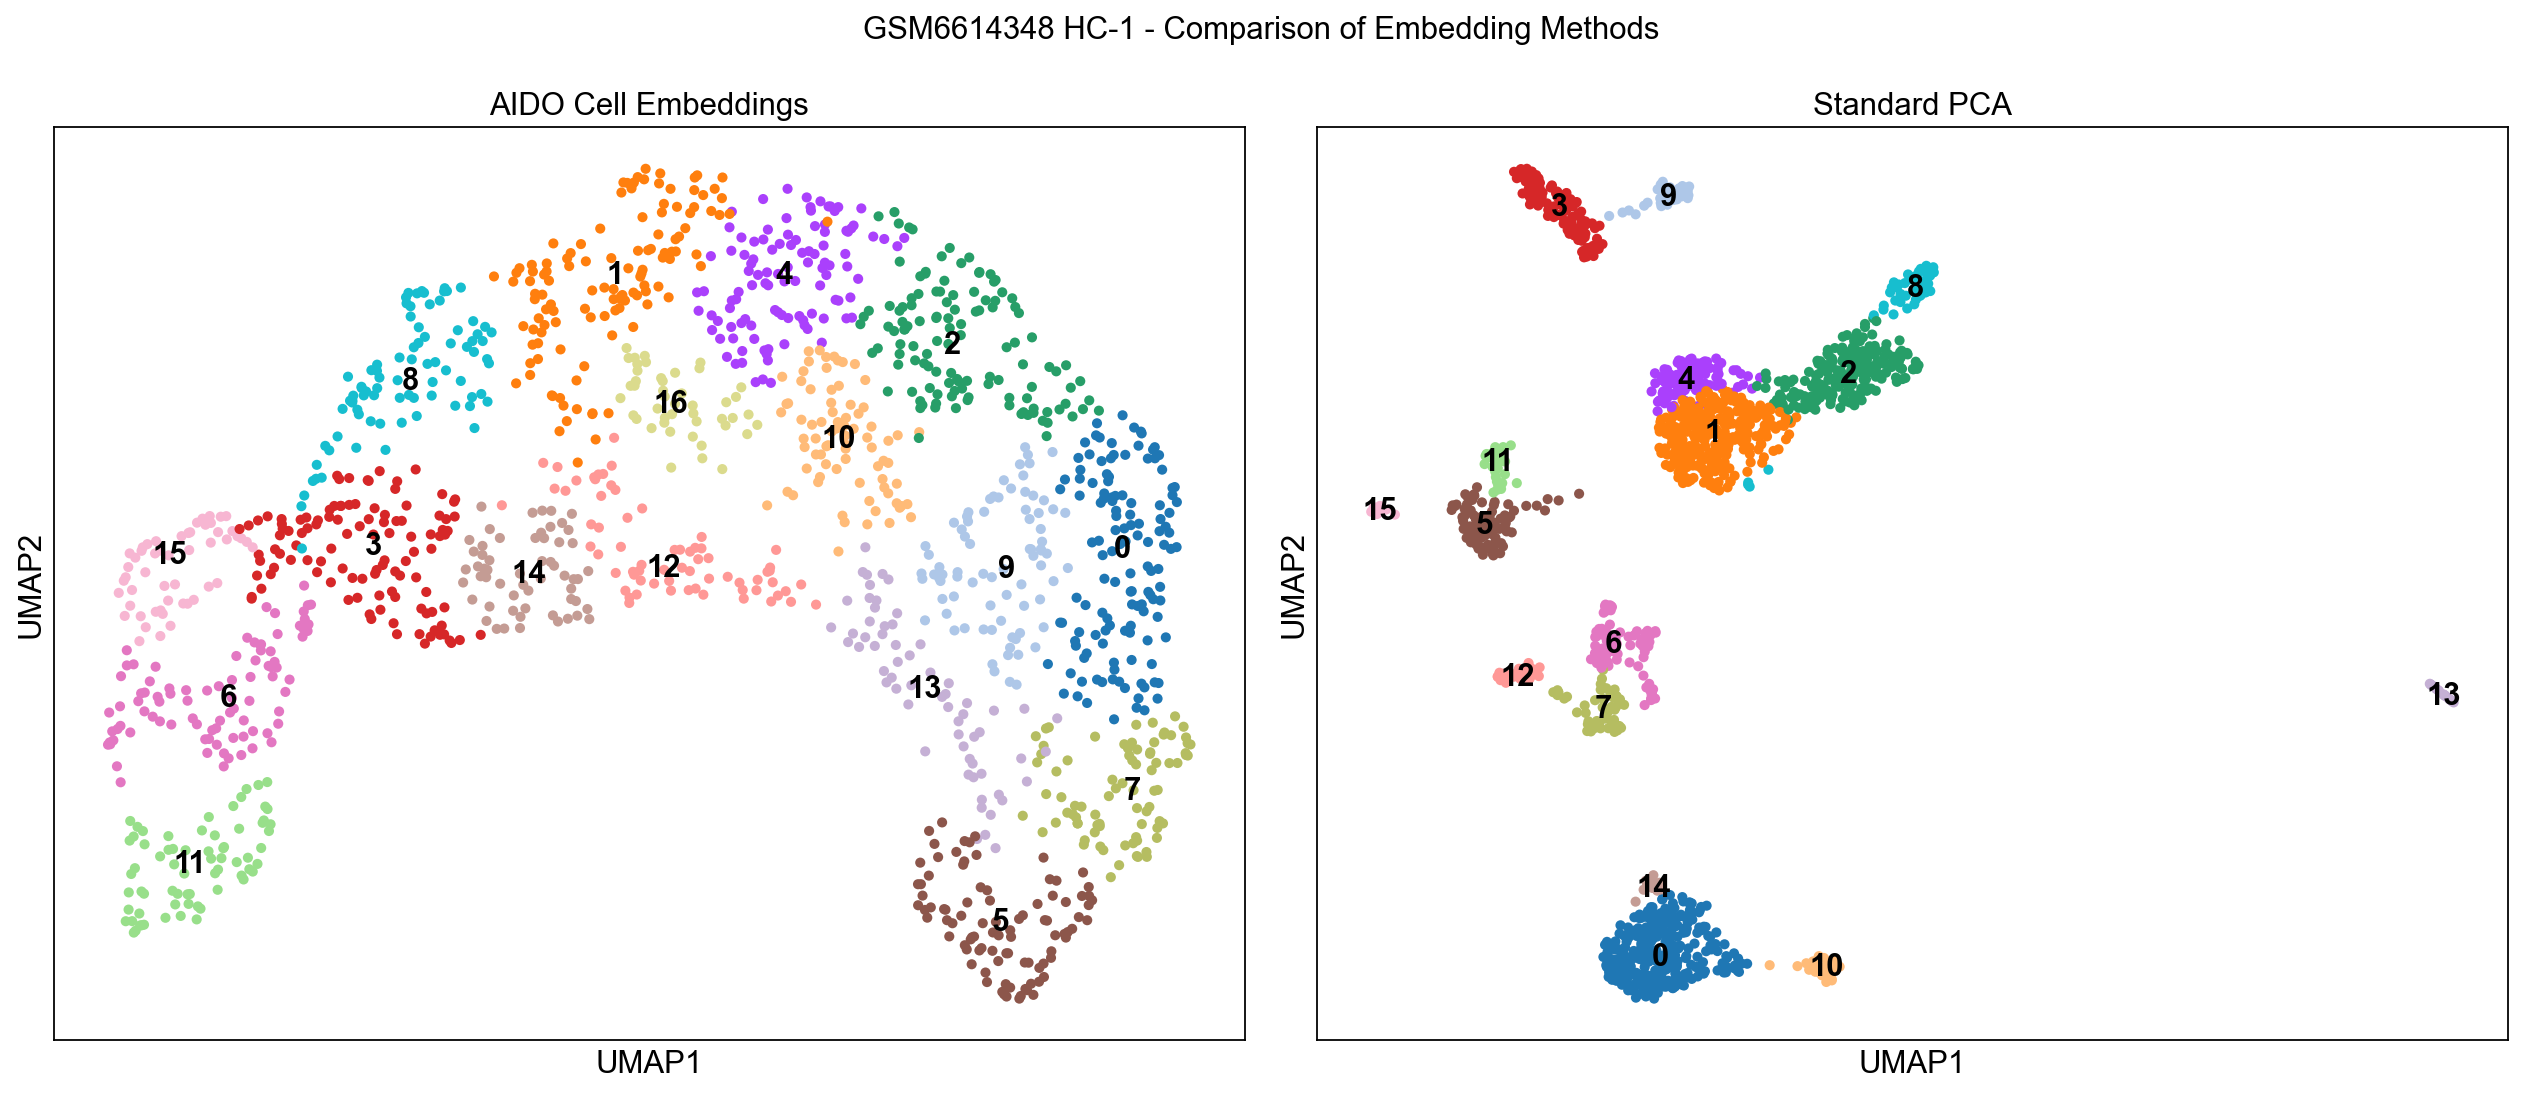

In [17]:
# Compare UMAPs side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# AIDO embeddings UMAP
sc.pl.umap(adata, color='leiden', ax=ax1, show=False, legend_loc='on data', title='AIDO Cell Embeddings')

# Standard PCA UMAP
sc.pl.umap(adata_standard, color='leiden', ax=ax2, show=False, legend_loc='on data', title='Standard PCA')

plt.suptitle('GSM6614348 HC-1 - Comparison of Embedding Methods', fontsize=14)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "comparison_umap.png", dpi=300, bbox_inches='tight')
plt.show()

